In [33]:
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv("../../data/clean/bitcoin_prices.csv")
df = df.iloc[::24, :]

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2018,1,1)
end_date = datetime.datetime(2019,1,1)
df = df[df["Time"] > start_date]
df = df[df["Time"] < end_date]

print(df.columns)

Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume'], dtype='object')


In [34]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import sys
import datetime
import backtrader as bt
import backtrader.analyzers as btanalyzers

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

### Buy and HODL
class BaselineStrategy(bt.Strategy):
    
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            cash = self.broker.get_cash()
            limit_price = self.data.close[0] * 1.01
            size = (cash * 0.999) / limit_price
            print(cash, self.data.close[0], limit_price, size)
            self.buy(exectype=bt.Order.Limit, size=size)

cerebro = bt.Cerebro()

from_date=datetime.datetime(2015, 7, 1)
to_date = datetime.datetime(2020, 12, 30)

# Create data feeds
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

cerebro.broker.setcash(10000.0)
cerebro.broker.addcommissioninfo(CommInfoFractional())
cerebro.broker.setcommission(commission=0.003, margin=False, mult=1.0, commtype=None, percabs=True, stocklike=False, interest=0.0, interest_long=False, leverage=1.0, automargin=False, name=None)
cerebro.broker.set_coc(True) # cheat_on_close to true (allow buying at same price to avoid order failing with margin)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

cerebro.addobserver(bt.observers.DrawDown)

# Add the strategy
cerebro.addstrategy(BaselineStrategy)

# Run the strategy
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

strats = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-01-01, Close, 13565.00
10000.0 13565.0 13700.65 0.729162484991588
2018-01-02, Close, 14761.01
10000.0 14761.01 14908.6201 0.6700821359047173
2018-01-03, Close, 15067.99
10000.0 15067.99 15218.6699 0.6564305596772291
2018-01-04, BUY EXECUTED, 14890.00
2018-01-04, Close, 14940.04
2018-01-05, Close, 16727.02
2018-01-06, Close, 16841.44
2018-01-07, Close, 16220.20
2018-01-08, Close, 14948.26
2018-01-09, Order Canceled/Margin/Rejected
2018-01-09, Close, 14587.41
2018-01-10, Close, 14473.99
2018-01-11, Order Canceled/Margin/Rejected
2018-01-11, Close, 13470.71
2018-01-12, Close, 13730.02
2018-01-13, Close, 14165.00
2018-01-14, Close, 13423.01
2018-01-15, Close, 13909.96
2018-01-16, Close, 10720.00
2018-01-17, Close, 11358.00
2018-01-18, Close, 11579.00
2018-01-19, Close, 11340.01
2018-01-20, Close, 12895.00
2018-01-21, Close, 11366.07
2018-01-22, Close, 10381.19
2018-01-23, Close, 10981.05
2018-01-24, Close, 11180.51
2018-01-25, Close, 11199.99
2018-01

OrderedDict([('rtot', 4.54223322981692),
             ('ravg', 0.00228482556831837),
             ('rnorm', 0.7785101922745346),
             ('rnorm100', 77.85101922745345)])
Returns: None
OrderedDict([('sharperatio', 0.630572322675444)])
Sharpe Ratio: None
OrderedDict([(2015, 0.5500143613505235),
             (2016, 1.2299819172983928),
             (2017, 13.482689253460002),
             (2018, -0.7389147778949815),
             (2019, 0.9493389662793232),
             (2020, 2.685622890180402)])
Annual Return: None
AutoOrderedDict([('len', 1),
                 ('drawdown', 1.1324638558856808),
                 ('moneydown', 10755.669919510023),
                 ('max',
                  AutoOrderedDict([('len', 1082),
                                   ('drawdown', 83.75641478850821),
                                   ('moneydown', 579694.3176152146)]))])
Drawdown: None
AutoOrderedDict([('total', AutoOrderedDict([('total', 1), ('open', 1)]))])
Trade Analyzer: None


<IPython.core.display.Javascript object>


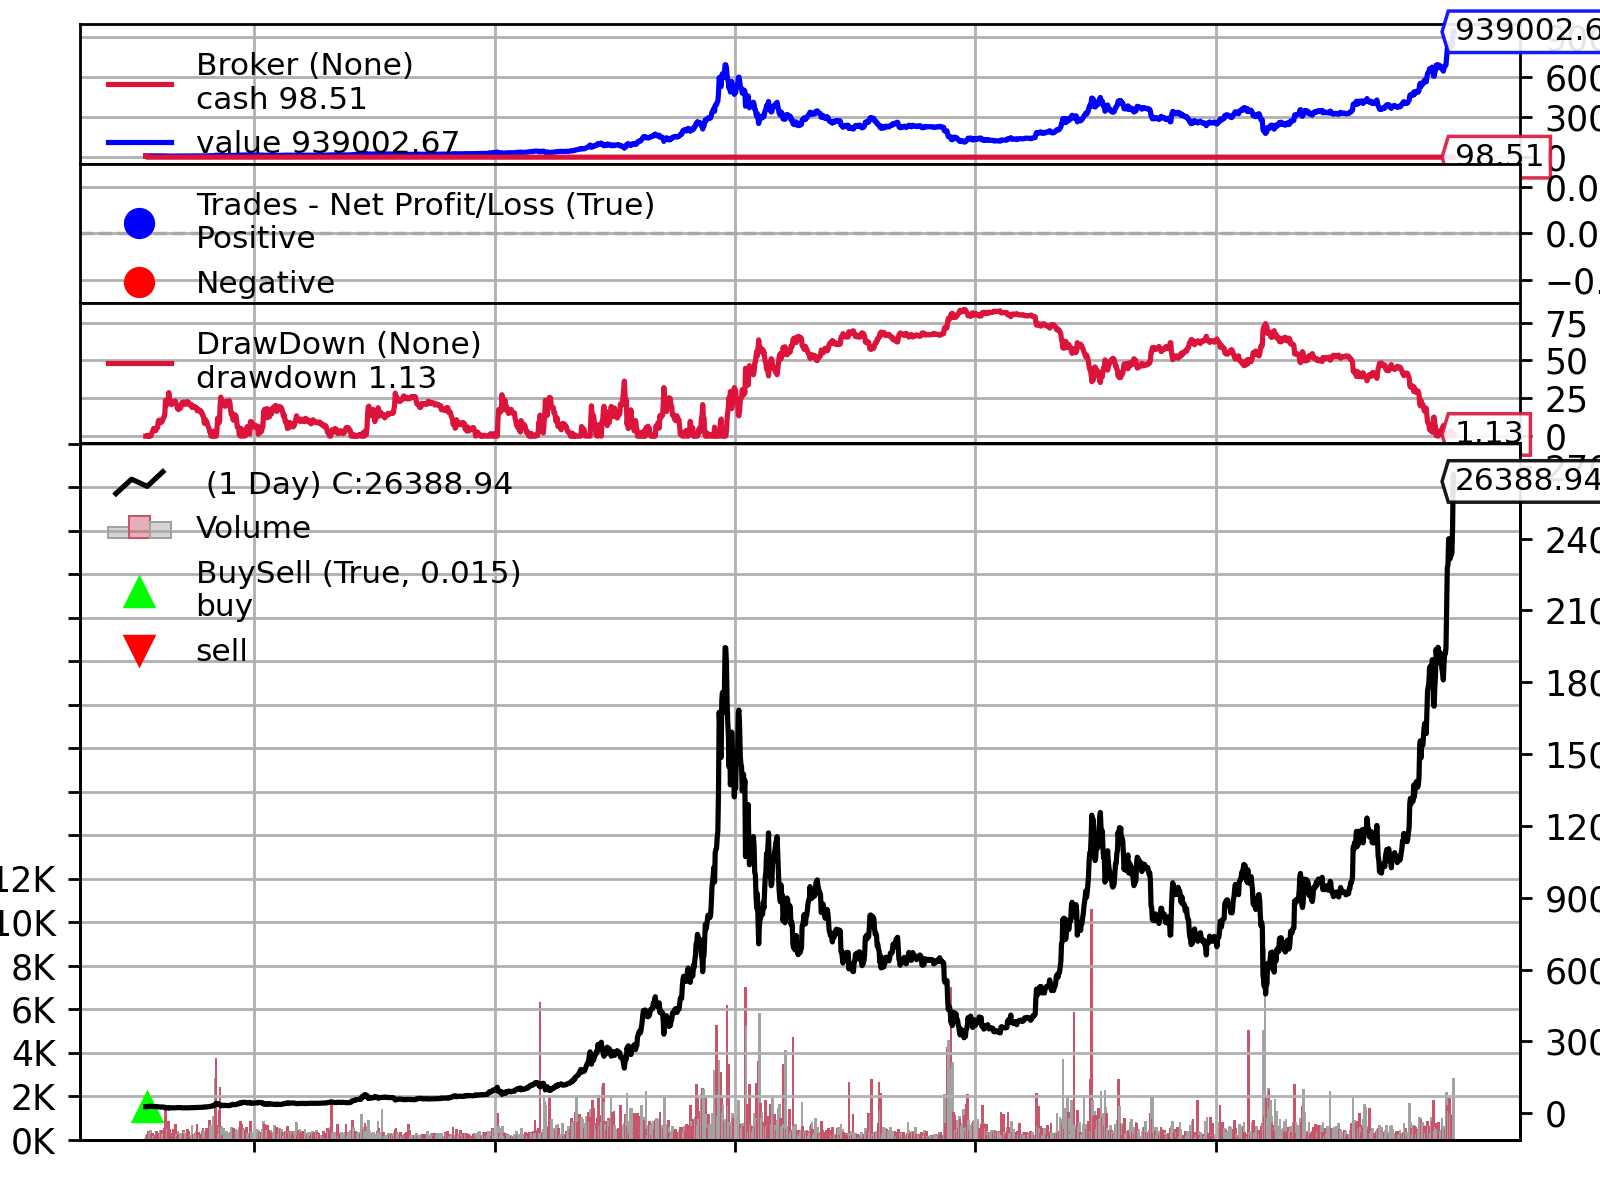

[[<Figure size 640x480 with 5 Axes>]]

In [31]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())


<IPython.core.display.Javascript object>


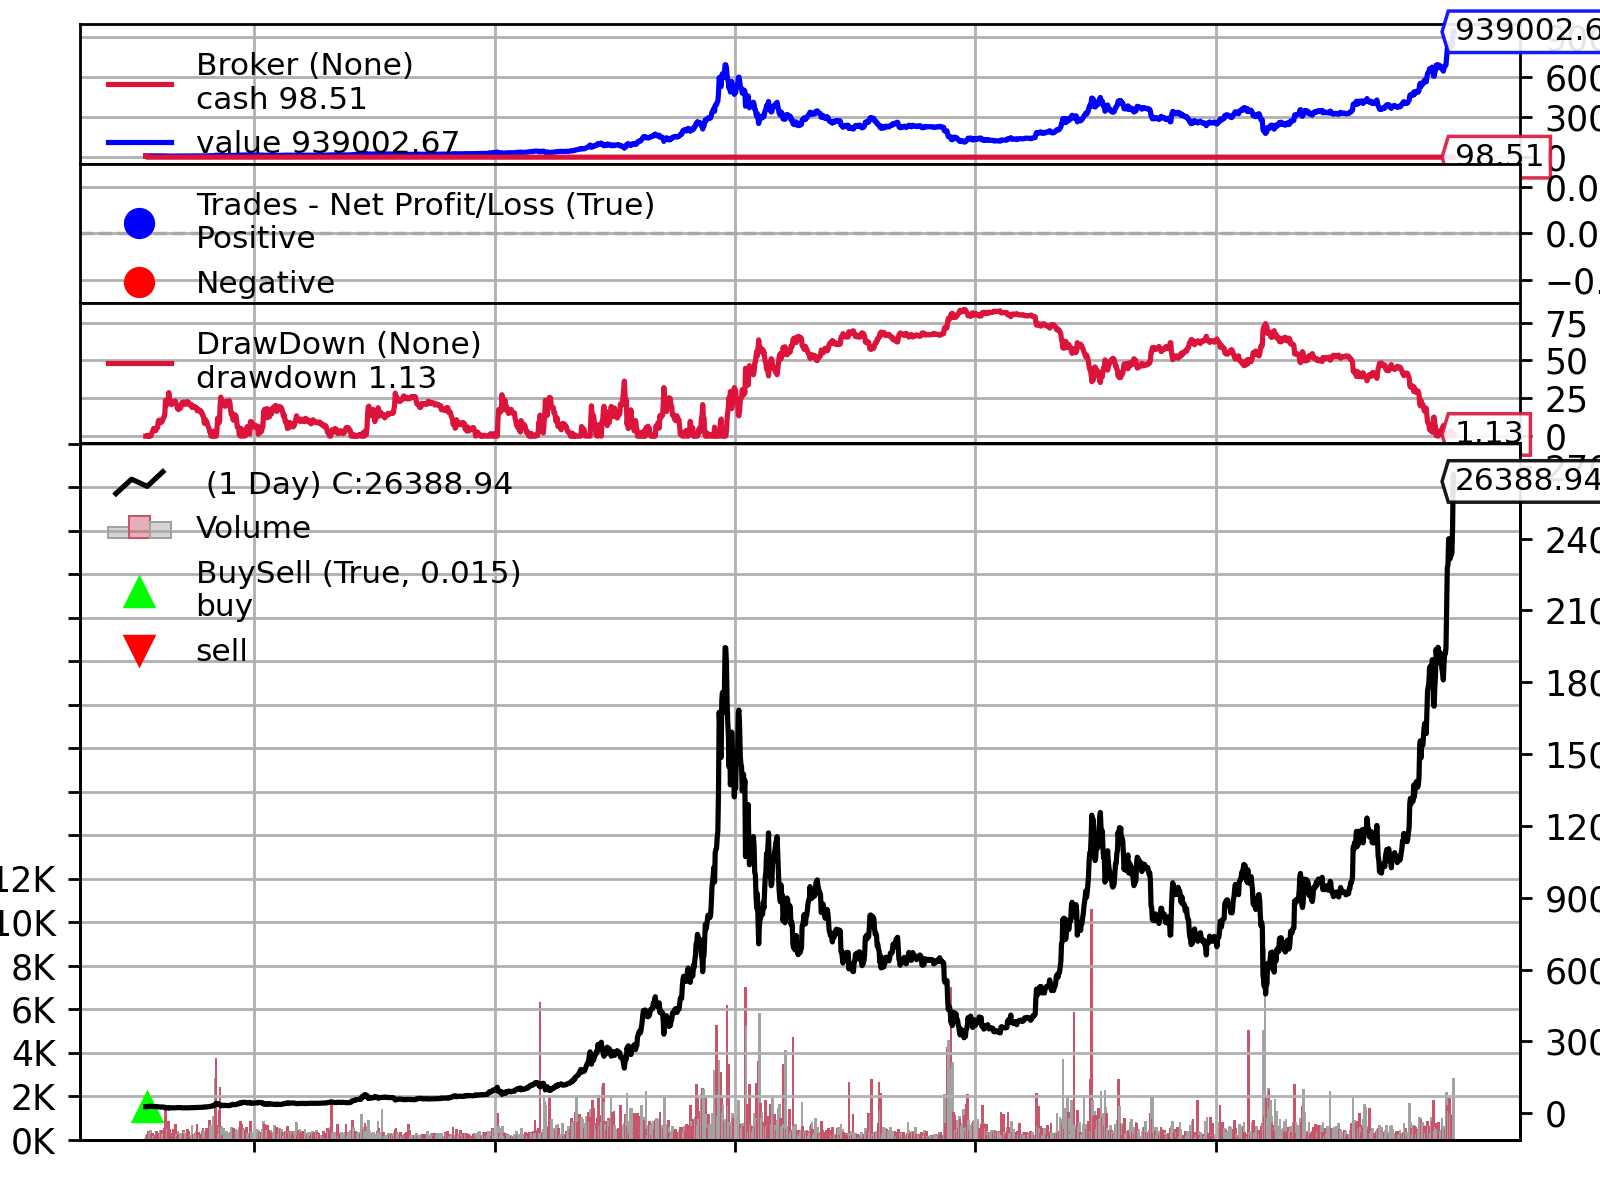

[[<Figure size 640x480 with 5 Axes>]]

In [32]:
cerebro.plot()